In [1]:
import tensorflow as tf
import numpy as np

In [2]:
tf.logging.set_verbosity(5)

# General CNN module

Okay so as much as I like the inbuilt `tf.nn` functions, it didn't really work out for me. I could've tweaked the parameters further, but that is a pain because it takes a very long time to run each _test_. Instead, I'm going to build a model using `tf.layers` and use `tf.estimator` to work out the details.

There's already a very well made model that they've used to optimize for MNIST in the tutorial;  
I'm going to use that as inspiration and try make one on my own

In [3]:
def CNN (features, labels, mode):
    
    # Input layer
    input_layer = tf.reshape(features["x"], [-1,28,28,1])
    
    # First convolutional layer
    # 32 Filters of Kernel Size 5x5
    # Using ReluS
    conv_1 = tf.layers.conv2d(inputs = input_layer, filters = 32, kernel_size = [5,5], activation = tf.nn.relu, padding = "same")
    
    # First Pooling Layer
    # Pooling 2x2 pixels into one using max pooling
    pool_1 = tf.layers.max_pooling2d(inputs = conv_1, pool_size = [2,2], strides = 2)
    
    # Second convolutional layer
    # Essentially the same as conv_1 but with 64 filters
    conv_2 = tf.layers.conv2d(inputs = pool_1, filters = 64, kernel_size = [5,5], activation = tf.nn.relu, padding = "same")
    
    # Second Pooling Layer
    # Same as pool_1
    pool_2 = tf.layers.max_pooling2d(inputs = conv_2, pool_size = [2,2], strides = 2)

    pool_2_flat = tf.reshape(pool_2, [-1,7*7*64])
    dense = tf.layers.dense(inputs=pool_2_flat, units=1024, activation=tf.nn.relu)
    
    dropout = tf.layers.dropout(inputs = dense, rate = 0.4, training = mode == tf.estimator.ModeKeys.TRAIN)

    # Final output layer, logits
    # Activation by default is linear
    logits = tf.layers.dense(inputs = dropout, units = 10)
    
    # The tutorial used three different modes for the model
    # TRAIN: to train based on a given dataset
    # PREDICT: give predictions with the current activations over some new data
    # EVAL: Evaluate the accuracy of the current model
    
    # TRAIN, PREDICT and EVAL are used when the model is called with train(), predict() and evaluate() respectively
    
    predictions = {"Class": tf.argmax(input = logits, axis = 1), "Probabilities": tf.nn.softmax(logits, name = "softmax")}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)

    # Calculate Loss (for TRAIN and EVAL modes)
    # We need to convert our label to a onehot tensor
    # Using cross entropy as the cost function
    
    hot_labels = tf.one_hot(indices = tf.cast(labels, tf.int32), depth = 10)
    cost = tf.losses.softmax_cross_entropy(onehot_labels = hot_labels, logits = logits)
    cost = tf.identity(cost, "cost")
    # We need to define a training optimizer when the model is called in train
    # This is the core part of the model
    # Using Gradient Descent, cuz bae af
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdadeltaOptimizer()
        train_op = optimizer.minimize(loss = cost, global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = cost, train_op = train_op)

    # Adding the ability to return accuracy
    evaluation = {"Accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["Class"])}
    return tf.estimator.EstimatorSpec(mode = mode, loss = cost, eval_metric_ops = evaluation)

## Preprocessing the data
I need to download and process the data before it's compatible with the `tf.estimator` that my model function would return.  

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets('data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/', one_hot = False, validation_size = 0)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [6]:
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

In [7]:
print(train_data.shape, train_labels.shape)
print(eval_data.shape, eval_labels.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


## Displaying Images
So I spent some time *figur*ing out how to use `matplotlib` to display images.  
I made a nice general `gen_images` function that accepts the image dataset, the dimensions of the grid of images that you want to display and the image shape as parameters.  
`gen_images` returns a pyplot that has the images as subplots. The images are chosen randomly.  
It's pretty neat.  

In [8]:
import matplotlib.pyplot as plt
import random
def gen_images(arr, grid_dimensions, img_shape):
    fig, axarr = plt.subplots( nrows = grid_dimensions[0], ncols = grid_dimensions[1], figsize = grid_dimensions)
    for i in range(0,grid_dimensions[0]):
        for j in range(0,grid_dimensions[1]):
            two_d = ((1-np.reshape(arr[random.randint(0,arr.shape[0])], img_shape))*255).astype(np.uint8)
            axarr[i,j].imshow(two_d, cmap='gray', aspect='equal')
            axarr[i,j].axis('off')
    return plt

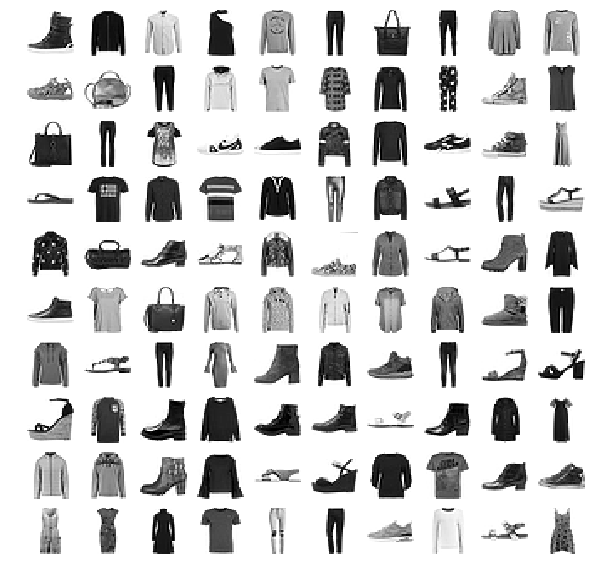

In [9]:
gen_images(train_data, (10,10), (28,28)).show()

## Inputting the data into the model

Okay, I need to use an _Estimator Input Function_. Seemed complex af in the beginning, but it's pretty simple at the base level. It's exactly what the name says it does. In the `linear_model`, we had `feed_dict` that put the values into the `tf.placeholder`s that we created. In a `tf.estimator` model, we have to use one of the many functions under `tf.estimator.inputs`. You basically put all the parameters into a function and pass the function object into the estimator, which seems retarded but I guess it would have its advantages.  

Still retarded though.

In [10]:
batch_size = 400
epochs = 1

There is more to the `input_fn`. I can't use the same function for the training and the evaluation.  
cuz that would be utterly nonsensical right.  
  
Okay, so since all the parameters are passed via the `input_fn`, I can't really change the dataset while calling the estimator in `EVAL` mode. So, I need to make a separate `eval_input_fn` and set it to the evaluation data set, and set the `num_epochs` to 1.  

I really like `tf.layers` but there must be a better way to do this.  

In [11]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=batch_size,
    num_epochs=epochs,
    shuffle=True)

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

`tf.estimator.Estimator`s are by default configured to display the loss after every 100 steps.  

I don't like that since 100 is an arbitrary number that doesn't concretely show how my model is working.  

So I calculated the number of steps each epoch takes manually and used `tf.estimator.RunConfig` to create a config object that I can pass as a parameter to my `tf.estimator.Estimator`. The parameter in question is `save_summary_steps`.  
`tf.estimator.RunConfig` that can be used. Things liks `save_checkpoints_secs`.

Okay that **doesn't work**.
But I still tweaked some of the parameters to my liking.

In [12]:
epoch_steps = train_data.shape[0]/batch_size
config = tf.estimator.RunConfig(log_step_count_steps = epoch_steps, save_summary_steps = epoch_steps, save_checkpoints_steps = epoch_steps)
#logging_hook = tf.train.LoggingTensorHook(tensors = {"loss":"cost"}, every_n_iter=epoch_steps)

In [13]:
mnist_classifier = tf.estimator.Estimator(model_fn = CNN, model_dir="/tmp/cnn-data/fashion/", config=config)

INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_num_worker_replicas': 1, '_tf_random_seed': None, '_service': None, '_log_step_count_steps': 150.0, '_is_chief': True, '_master': '', '_task_id': 0, '_model_dir': '/tmp/cnn-data/fashion/', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbb5bedc0b8>, '_save_summary_steps': 150.0, '_num_ps_replicas': 0, '_save_checkpoints_steps': 150.0, '_save_checkpoints_secs': None}


In [14]:
mnist_classifier.train(train_input_fn)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/cnn-data/fashion/model.ckpt-45000
INFO:tensorflow:Saving checkpoints for 45001 into /tmp/cnn-data/fashion/model.ckpt.
INFO:tensorflow:loss = 0.584249, step = 45001
INFO:tensorflow:loss = 0.592428, step = 45101 (21.789 sec)
INFO:tensorflow:Saving checkpoints for 45150 into /tmp/cnn-data/fashion/model.ckpt.
INFO:tensorflow:Loss for final step: 0.601371.


In [15]:
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2017-12-13-19:52:09
INFO:tensorflow:Restoring parameters from /tmp/cnn-data/fashion/model.ckpt-45150
INFO:tensorflow:Finished evaluation at 2017-12-13-19:52:11
INFO:tensorflow:Saving dict for global step 45150: Accuracy = 0.8051, global_step = 45150, loss = 0.555741
{'loss': 0.55574089, 'global_step': 45150, 'Accuracy': 0.80510002}
